SETUP TENSORFLOW IN UR SYSTEM 

In [ ]:
# this part of code import all modules we will use in our model 
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import time
import uuid 

SETUP TENSORFLOW DEPENDENCIES

In [1]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

#LIMITING GPU GROWTH 


In [2]:
# # Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)
# IF U HAVE GPU IN UR SYSTEM 

#Creating Paths

In [3]:
# this creates a directory named data and makes subdirectories positive, negative and anchor in it 
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

NameError: name 'os' is not defined

##2. Collect Positives and Anchors

2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# https://www.kaggle.com/datasets/atulanandjha/lfwpeople
# download datset from here 

In [ ]:
##no need do to this step just unzip the files manually and put in the directory same as ur notebook
# !tar -xf lfw.tgz(just for unzipping)

In [ ]:
for directory in os.listdir('lfw_funneled'):#Selects each item in given directory 
    for file in os.listdir(os.path.join('lfw_funneled', directory)):#selects path for each file in that directory 
        EX_PATH = os.path.join('lfw_funneled', directory, file)#assigns path with file type
        NEW_PATH = os.path.join(NEG_PATH, file)#changes path
        os.replace(EX_PATH, NEW_PATH)#assigns new path 
        #ensure that u extracted dataset properly before running this block , this block will return all images in negative folder created earlier 

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw_funneled'

2.2 Collect Positive and Anchor Classes

In [ ]:
import uuid #universally unique identifiers  can be used to create unique filenames or directory names. However, it does not handle saving images or managing paths

In [ ]:
ANC_PATH
POS_PATH
#try running if paths are created properly 

'data\\positive'

In [ ]:
# ignore these lines pls
#testing web cam 
#displayes image also 
#this code connects opencv and webcam of ur system
# cap = cv2.VideoCapture(0) #webcam device might be diffrent try with 0,1,2,3,4 etc.. 

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # Convert BGR to RGB for correct color representation
#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#     # Display frame using Matplotlib
#     plt.imshow(frame_rgb)
#     plt.axis('off')
#     plt.show()

#     # Wait for 'q' key to exit
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
#interrept not working correctly 
# cap.release()
# cv2.destroyAllWindows()



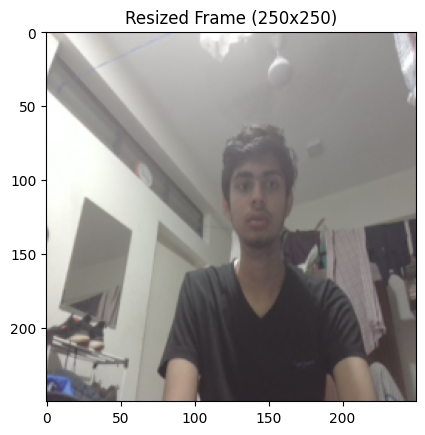

In [ ]:
import cv2
import time #if u want to exit manually after some delay we need to import time module

# Establish a connection to the webcam
cap = cv2.VideoCapture(0)#try this with different video inputs (0,1,2,3..) might be diffrent for ur system

# start_time = time.time()  # Get the current time

while cap.isOpened():
    ret, frame = cap.read()
    
    # Show image back to screen
    # cv2.imshow('Image Collection', frame)
    resized_frame = cv2.resize(frame, (250, 250), interpolation=cv2.INTER_AREA)#resizing to 250X250
    cv2.imshow('Resized Image', resized_frame)
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, resized_frame)
     # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, resized_frame)
    
    # Breaking gracefully after 5 seconds
    # if (time.time() - start_time) > 5:  # Check if 5 seconds have passed
    #     break

    if cv2.waitKey(1) & 0xFF == ord('q'):  # Allow manual exit
        break
    

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()
frame.shape
plt.imshow(cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.title("Resized Frame (250x250)")
plt.show()



SECTION 3 

3.1 Get Image Directories

In [ ]:
anchor = tf.data.Dataset.list_files(f"{ANC_PATH}/*.jpg").take(300)
positive = tf.data.Dataset.list_files(f"{POS_PATH}/*.jpg").take(300)
negative = tf.data.Dataset.list_files(f"{NEG_PATH}/*.jpg").take(300)


In [ ]:
dir_test = anchor.as_numpy_iterator()

In [ ]:
print(dir_test.next())

b'data\\anchor\\b42043bc-01c4-11f0-9b3a-c85ea927c210.jpg'


3.2 Preprocessing - Scale and Resize

In [6]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [ ]:
img = preprocess('data\\anchor\\b42043bc-01c4-11f0-9b3a-c85ea927c210.jpg')
img.numpy().max() 

0.9379902

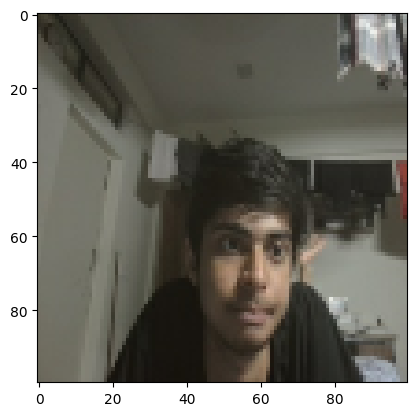

In [ ]:
plt.imshow(img)

In [ ]:
# dataset.map(preprocess)

SECTION 3.3

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
samples = data.as_numpy_iterator()
exampple = samples.next()

In [ ]:
exampple

(b'data\\anchor\\00688c4d-01c5-11f0-bfda-c85ea927c210.jpg',
 b'data\\positive\\9b7f3a63-01c3-11f0-9816-c85ea927c210.jpg',
 1.0)

SECTION 3.4


In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [5]:
res = preprocess_twin(*exampple)
plt.imshow(res[1])

NameError: name 'preprocess_twin' is not defined

In [ ]:
res[2]

1.0

In [ ]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)